# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 6
# Reg-Logistic Regression, ROC, and Data Imputation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):109A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from math import isclose


from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline

## Automated Breast Cancer Detection

In this homework, we will consider the problem of early breast cancer detection from X-ray images. Specifically, given a candidate region of interest (ROI) from an X-ray image of a patient's breast, the goal is to predict if the region corresponds to a malignant tumor (label 1) or is normal (label 0). The training and test data sets for this problem is provided in the file `hw6_dataset.csv`. Each row in these files corresponds to a ROI in a patient's X-ray, with columns 1-117 containing features computed using standard image processing algorithms. The last column contains the class label, and is based on a radiologist's opinion or a biopsy. This data was obtained from the KDD Cup 2008 challenge.

The data set contain a total of 69,098 candidate ROIs, of which only 409 are malignant, while the remaining are all normal. 

*Note*: be careful of reading/treating column names and row names in this data set.

In [2]:
data = pd.read_csv('hw6_dataset.csv',header=None )

In [3]:
data.rename(columns={117:'class'}, inplace=True)

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,class
0,-0.144,-0.143,-0.1160,-0.1030,0.226,0.210,-0.9800,-0.780,-0.474,-0.447,...,0.925,0.516,0.34400,0.906,-1.1300,-0.552,0.553,-0.417,0.2560,0.0
1,-0.011,0.138,-0.2230,-0.1730,0.188,0.284,-0.0522,-0.256,0.129,0.427,...,-0.593,0.452,0.00785,-0.533,-0.0789,0.705,0.906,0.216,-0.0723,0.0
2,0.212,-0.313,0.2660,0.2320,-1.190,-1.150,-1.8100,-1.560,-1.250,-1.200,...,-0.816,1.570,0.39400,1.340,-1.1800,-2.700,-0.926,-2.650,-0.0447,0.0
3,0.215,-0.184,0.0274,0.0494,0.443,0.463,-1.0500,-0.941,-0.531,-0.394,...,0.634,0.111,0.37100,0.859,-0.9930,-0.492,0.363,0.326,-0.0528,0.0
4,0.279,-0.197,0.1270,0.0973,-0.213,-0.150,-1.3200,-0.994,-1.110,-1.090,...,-0.640,0.485,0.29500,0.403,-1.1200,-0.343,0.468,-0.820,0.4350,0.0


In [5]:
# observe data is already roughly normalized and does not include missing values so no processing needs to happen
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,class
count,69098.000000,69098.000000,69098.000000,69098.000000,69098.000000,69098.000000,69098.000000,69098.000000,69098.000000,69098.000000,...,69098.000000,69098.000000,69098.000000,69098.000000,69098.000000,6.909800e+04,69098.000000,69098.000000,69098.000000,69098.000000
mean,-0.001000,-0.001319,0.000782,0.000313,-0.003161,-0.002642,0.000845,-0.000382,0.002176,0.002582,...,0.002565,-0.001242,-0.001661,0.002460,-0.000910,-6.900981e-08,-0.001279,0.000268,0.000844,0.005919
std,1.211806,1.057307,1.025779,1.033022,0.983596,0.988935,0.999774,0.998935,1.005915,1.004493,...,1.003114,0.999678,0.998775,1.003224,1.000273,9.994056e-01,1.000918,0.999318,1.024488,0.076708
min,-316.000000,-147.000000,-71.400000,-81.400000,-3.080000,-9.120000,-2.070000,-1.910000,-1.570000,-1.500000,...,-15.200000,-7.460000,-32.900000,-7.780000,-1.220000,-4.710000e+00,-5.450000,-6.340000,-23.200000,0.000000
25%,-0.064700,-0.040900,-0.253000,-0.214000,-0.569000,-0.553000,-0.532000,-0.597000,-0.711000,-0.728000,...,-0.458000,-0.491000,-0.334000,-0.520000,-0.857000,-2.470000e-01,-0.606000,-0.097875,-0.259000,0.000000
50%,0.024400,0.103000,0.095600,0.085000,-0.099200,-0.098800,0.013700,-0.075300,-0.227000,-0.235000,...,-0.102000,0.161000,0.205000,-0.269000,-0.132000,3.210000e-01,0.269000,0.326000,-0.142000,0.000000
75%,0.094200,0.176000,0.360750,0.313000,0.450000,0.434000,0.582000,0.513000,0.488000,0.498000,...,0.322000,0.559000,0.399000,0.134000,0.645000,6.450000e-01,0.801000,0.583000,0.006707,0.000000
max,1.340000,3.750000,2.030000,1.750000,28.000000,26.900000,11.200000,22.200000,16.700000,22.500000,...,13.000000,6.310000,17.000000,10.600000,17.700000,1.410000e+00,1.440000,1.420000,40.600000,1.000000


## Question 1: Beyond Classification Accuracy


0.  Split the data set into a training set and a testing set.  The training set should be 75% of the original data set, and the testing set 25%.  Use `np.random.seed(9001)`.

1. Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation. 
    1. How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients? 
    2. Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?
    
For applications with imbalanced class labels, in this case when there are many more healthy subjects ($Y=0$) than those with cancer ($Y=1$), the classification accuracy may not be the best metric to evaluate a classifier's performance. As an alternative, we could analyze the confusion table for the classifier. 

<ol start="3">
<li> Compute the confusion table for both the fitted classifier and the classifier that predicts all 0's.</li>
<li> Using the entries of the confusion table compute the *true positive rate* and the *true negative rate* for the two classifiers. Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.</li>
<li> What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?</li>
</ol>
*Hint:* You may use the `metrics.confusion_matrix` function to compute the confusion matrix for a classification model.

In [42]:
np.random.seed(9001)
msk = np.random.rand(len(data)) < 0.75
data_train = data[msk]
data_test = data[~msk]

In [50]:
# function for calculating accuracy of classification
def accuracy (y, predict):
    return 1 - np.sum((predict < .5) != (y == 0))/len(y)

In [46]:
# split data into X and y
y = data_train['class']
X = data_train[data_train.columns[data_train.columns != 'class']]
y_test = data_test['class']
X_test = data_test[data_train.columns[data_train.columns != 'class']]

In [47]:
# LogisticRegressionCV uses CV to select a regularization parameter. The function uses L2 by default. 
log = LogisticRegressionCV()
log.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [61]:
print('Logistic Model')
print('Training Set Accuracy = %f' % accuracy(y, log.predict(X)))
print('Test Set Accuracy = %f' % accuracy(y_test, log.predict(X_test)))

Logistic Model
Training Set Accuracy = 0.995597
Test Set Accuracy = 0.995026


In [62]:
print('Label 0 on all patients')
print('Training Set Accuracy = %f' % accuracy(y, np.zeros(len(X))))
print('Test Set Accuracy = %f' % accuracy(y_test, np.zeros(len(X_test))))

Label 0 on all patients
Training Set Accuracy = 0.994039
Test Set Accuracy = 0.994207


#### Answers to 2
**How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients?**

The fitted model performs better (as far as classification accuracy is concerned) than the 'normal' model. 

Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?

I do not think they are. The difference both in train and test sets is $< .001$ when comparing classification accuracy. That is incredibly small difference making it very hard to use as a metric for comparison. 


In [68]:
confusion_log = metrics.confusion_matrix(y_test, log.predict(X_test))
confusion_log 

array([[16984,     6],
       [   79,    20]])

In [155]:
confusion_normal = metrics.confusion_matrix(y_test, np.zeros(len(X_test)))
confusion_normal

array([[16990,     0],
       [   99,     0]])

In [153]:
confusion_normal.ravel()

array([16990,     0,    99,     0])

In [197]:
tn_log, fp_log, fn_log, tp_log = confusion_log.ravel()
tn_norm, fp_norm, fn_norm, tp_norm = confusion_normal.ravel()
tpr_log =  tp_log /(tp_log + fn_log)
tpr_log

0.20202020202020202

In [198]:
tnr_log= tn_log/(tn_log + fp_log)
tnr_log

0.99964685108887585

In [199]:
tpr_norm =  tp_norm /(tp_norm + fn_norm)
tpr_norm

0.0

In [200]:
tnr_norm= tn_norm/(tn_norm + fp_norm)
tnr_norm

1.0

#### Answer to 4

The true positive rate means the rate by which the model identifies someone with cancer correctly as positive. The true negative rate means the rate by which the model identifies someone without cancer correctly as negative. We see that the fitted model has a much superior TPR (compared to 0 with the 0's classifier), but has a slightly lower TNR.

In [205]:
fpr = fp_log/ (fp_log + tn_log)
fpr

0.0003531489111241907

#### Answer to 5

FPR is related to the TNR in that FPR + TNR = 1, which makes sense becuase if the classifier doesn't correctly identify a negative person as negative, it by default has to falsley identify them as positive. The FPR and the TPR together represent the rate of the total population that are labled positive by the classifier. 

## Question 2: ROC Analysis

Another powerful diagnostic tool for class-imbalanced classification tasks is the Receiver Operating Characteristic (ROC) curve. Notice that the default logistic regression classifier in `sklearn` classifies a data point by thresholding the predicted class probability $\hat{P}(Y=1)$ at 0.5. By using a different threshold, we can adjust the trade-off between the true positive rate (TPR) and false positive rate (FPR) of the classifier. The ROC curve allows us to visualize this trade-off across all possible thresholds.


1. Display the ROC curve for the fitted classifier on the *test set*. In the same plot, also display the ROC curve for the all 0's classifier. How do the two curves compare?

2.  Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.
    - FPR = 0
    - FPR = 0.1
    - FPR = 0.5
    - FPR = 0.9
- Suppose a clinician told you that diagnosing a cancer patient as normal is *twice* as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold? 

- Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)? 

*Hint:* You may use the `metrics.roc_curve` function to compute the ROC curve for a classification model and the `metrics.roc_auc_score` function to compute the AUC for the model.

In [92]:
# Code from CS109 Lab
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 3))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

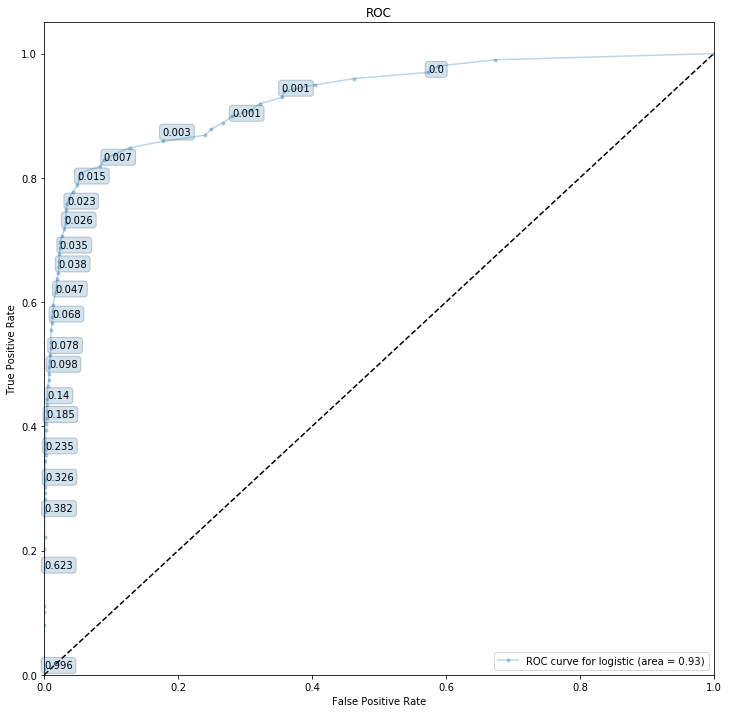

In [195]:
plt.figure(figsize=(12,12))
make_roc("logistic",log, y_test, X_test, labe=7, skip=2)
plt.show()

#### Answer to 1

The ROC of the logisitic classifier performs muhc better than the all 0's classifier represented by the dotted line from 0,0 to 1,1 at all points except the extremes at 0 and 1 FPR where it peforms equally.


In [286]:
# get ROC curve information, store them in a dataframe
fpr, tpr, thresholds=roc_curve(y_test, log.predict_proba(X_test)[:,1])
df = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':thresholds})

In [287]:
# 0 FPR 
df[df['fpr'] <= 0].sort_values('tpr').tail(1)

,fpr,threshold,tpr
1,0.0,0.940257,0.080808


In [288]:
# 0.1 FPR 
df[df['fpr'] <= 0.1].sort_values('tpr').tail(1)

,fpr,threshold,tpr
113,0.089052,0.007237,0.838384


In [289]:
# 0.5 FPR 
df[df['fpr'] <= 0.5].sort_values('tpr').tail(1)

,fpr,threshold,tpr
139,0.462507,0.000277,0.969697


In [290]:
# 0.9 FPR 
df[df['fpr'] <= 0.9].sort_values('tpr').tail(1)

,fpr,threshold,tpr
145,0.673455,0.000056,1.0


#### Answer to 2
The FPR increases as the threshold decreases which makes sense as a lower threshold makes it more likely to classify something as positive. 


Suppose a clinician told you that diagnosing a cancer patient as normal is twice as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold?
Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)?

In [291]:
# Create a weighted false rate column which is (FNR*2 + FPR), and sort to minimize
df = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':thresholds, 'weighted false rate': (fpr + 2*(1-tpr))})
df.sort_values('weighted false rate').head(1)

,fpr,threshold,tpr,weighted false rate
115,0.105827,0.005762,0.848485,0.408857


#### Answer to 3 

We would use threshold $.005$ giving an FPR of $.1$ and a TPR $.85$

In [292]:
roc_auc_score(y_test, log.predict_proba(X_test)[:,1])

0.93453784460258871

In [293]:
roc_auc_score(y_test, np.zeros(len(X_test)))

0.5

#### Answer to 4 

The difference in AUC is significant, with the logistic classifier model performing much better than the all 0's model. This was not the case with the classification accuracies which were essentially the same. 

## Question 3: Missing data

In this problem you are given a different data set, `hw6_dataset_missing.csv`, that is  similar to the one you used above (same column definitions and same conditions), however this data set contains missing values. 

*Note*: be careful of reading/treating column names and row names in this data set as well, it *may* be different than the first data set.


1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the regularized logistic regression as in Question 1 (use `LogisticRegressionCV` again to retune).  Report the overall classification rate and TPR in the test set.
2. Restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via mean imputation.  Split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
3. Again restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via a model-based imputation method. Once again split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
4. Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.

